## Cargar Bibliotecas y Herramientas 

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
#xgboost
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
#from nltk.stem import WordNetLemmatizer

# Word2vec
import gensim


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:

DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 128
W2V_WINDOW = 7
W2V_EPOCH = 3
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 600
EPOCHS = 14
BATCH_SIZE = 16

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "/content/drive/MyDrive/Mercantil/model3.h5"
WORD2VEC_MODEL = "/content/drive/MyDrive/Mercantil/model3.w2v"
TOKENIZER_MODEL = "/content/drive/MyDrive/Mercantil/tokenizer3.pkl"
ENCODER_MODEL = "/content/drive/MyDrive/Mercantil/encoder3.pkl"

## Carga e inspección de datos para entrenamiento

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Mercantil/banco_train_V2.xlsx')
                      # encoding =DATASET_ENCODING)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  6092 non-null   object
 1   date    6092 non-null   object
 2   user    6092 non-null   object
 3   text    6092 non-null   object
dtypes: object(4)
memory usage: 190.5+ KB


Elimina nulos

In [ ]:
df = df.dropna()

In [ ]:
df = df.drop(['Unnamed: 0.1.1.1'], axis=1) #Elimina columna no deseada

Verifica Equilibrio de data

In [ ]:
df.groupby('target').count()

,date,user,text
target,,,
NEGATIVE,3046,3046,3046
POSITIVE,3046,3046,3046


In [ ]:
df.sort_values('target', ascending=False, inplace=True) # Oredena data

In [ ]:
df.reset_index(drop=True, inplace=True) #reindexa

Ve data

In [ ]:
df.head(15)

,target,date,user,text
0,POSITIVE,2022-02-15 22:11:42,Luis Bastidas,facil sencillo
1,POSITIVE,2022-03-12 06:35:31,simon_cr,mejor
2,POSITIVE,2021-11-17 13:49:37,CastilloLeonC,pagar facturar rapidez sencillo online comodid...
3,POSITIVE,2021-11-21 20:11:10,pablojulioperez,excelentee
4,POSITIVE,2022-03-16 19:03:45,depensamiento86,llamal atender cliente querer felicita exce...
5,POSITIVE,2022-01-12 15:14:25,Grb0606,realizar pagar mensaje
6,POSITIVE,2021-07-28 23:09:04,francyyssq,gustar inininininformaciononononon francyys...
7,POSITIVE,2021-12-09 00:48:00,dahliabreu,pagar facturar rapidez sencillo online comodid...
8,POSITIVE,2021-11-05 01:27:01,johnnypettus,pagar facturar rapidez sencillo online comodid...
9,POSITIVE,2021-07-27 20:46:51,eduardolparedesm,onuevir poder transferir haciondo transferenci...


In [ ]:
#df.loc[len(df)] = ['POSITIVE','2022-01-02 14:48:20','Manuel Hurtado','muy bueno mejorar mucho']

Cuenta y grafica target

Text(0.5, 1.0, 'Dataset labels distribuition')

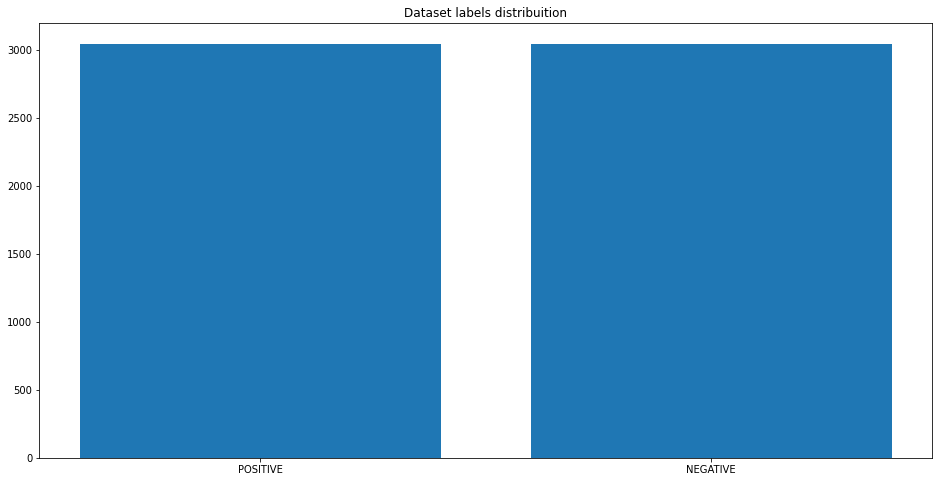

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Convierte texto en string

In [ ]:
df.text = df.text.apply(lambda x: str(x))

# Crea modelo de palabras

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 4873
TEST size: 1219


In [ ]:
documents = [_text.split() for _text in df_train.text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
w2v_model.most_similar("atencion")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('realizar', 0.2400476485490799),
 ('experiencia', 0.2350584715604782),
 ('afiliaciónacionacionacion', 0.2171759307384491),
 ('gustar', 0.216196209192276),
 ('resolver', 0.2046174705028534),
 ('acceso', 0.20220635831356049),
 ('mil', 0.20150288939476013),
 ('corriente', 0.1987532377243042),
 ('quedar', 0.1978641152381897),
 ('cargar', 0.1883651614189148)]

# Tokenizar Textos

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 3763
CPU times: user 75.5 ms, sys: 802 µs, total: 76.3 ms
Wall time: 76.3 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


CPU times: user 94.1 ms, sys: 0 ns, total: 94.1 ms
Wall time: 94.2 ms


In [ ]:
tokenizer

# Label Encoder

In [ ]:
labels = df_train.target.unique().tolist()
labels

['NEGATIVE', 'POSITIVE']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (4873, 1)
y_test (1219, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4873, 600)
y_train (4873, 1)

x_test (1219, 600)
y_test (1219, 1)


# Capa de incrustación

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(3763, 128)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 128)          481664    
                                                                 
 dropout_1 (Dropout)         (None, 600, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               91600     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 573,365
Trainable params: 91,701
Non-trainable params: 481,664
_________________________________________________________________


Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/14
275/275 [==============================] - 245s 889ms/step - loss: 0.6873 - accuracy: 0.5355 - val_loss: 0.6788 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 2/14
275/275 [==============================] - 244s 886ms/step - loss: 0.6828 - accuracy: 0.5532 - val_loss: 0.6784 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 3/14
275/275 [==============================] - 244s 888ms/step - loss: 0.6805 - accuracy: 0.5626 - val_loss: 0.6697 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 4/14
275/275 [==============================] - 243s 885ms/step - loss: 0.6735 - accuracy: 0.5763 - val_loss: 0.6690 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 5/14
275/275 [==============================] - 247s 897ms/step - loss: 0.6667 - accuracy: 0.5975 - val_loss: 0.6588 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 6/14
275/275 [==============================] - 247s 898ms/step - loss: 0.6633 - accuracy: 0.6114 - val_loss: 0.6392 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 7/14
275/275 [==========================

## Evaluate Model

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

77/77 [==============================] - 8s 105ms/step - loss: 0.6823 - accuracy: 0.7162

ACCURACY: 0.716160774230957
LOSS: 0.6822751760482788
CPU times: user 14.6 s, sys: 191 ms, total: 14.8 s
Wall time: 8.12 s


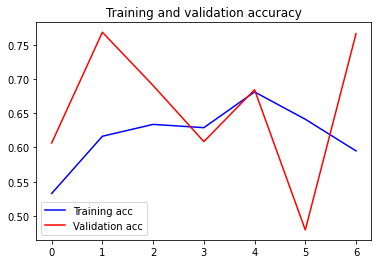

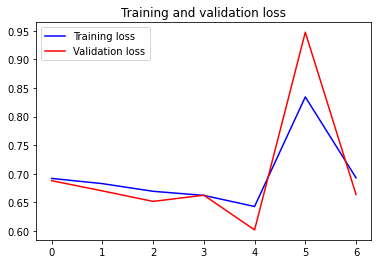

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}
       #,"elapsed_time": time.time()-start_at}  

## Predict

In [ ]:
predict("excelente mejora ser cliente fiel mercantil")

{'elapsed_time': 0.4409613609313965,
 'label': 'POSITIVE',
 'score': 0.6373392343521118}

In [ ]:
predict("desinstalar pedido propio aplicacion ahora no poder descargar solo suceder aplicacion")

{'elapsed_time': 0.1351020336151123,
 'label': 'NEGATIVE',
 'score': 0.1659519374370575}

In [ ]:
predict("rogar arreglar aplicacion no poder afiliar nuevo contacto")

{'elapsed_time': 0.1347217559814453,
 'label': 'NEGATIVE',
 'score': 0.16091537475585938}

In [ ]:
predict("no poder ingresar pagina")

{'elapsed_time': 0.14791297912597656,
 'label': 'NEGATIVE',
 'score': 0.3023050129413605}

In [ ]:
predict("aplicacion")

{'elapsed_time': 0.14213132858276367,
 'label': 'POSITIVE',
 'score': 0.6652573943138123}

In [ ]:
predict("No poder creer tener esperar tanto abrir cuenta")

{'elapsed_time': 0.132246732711792,
 'label': 'NEGATIVE',
 'score': 0.17155003547668457}

In [ ]:
predict("venezuela ser unico pais donde solicitar reposicion tarjeta decir ser favor no servicio gracias ")

{'elapsed_time': 0.344623327255249,
 'label': 'NEGATIVE',
 'score': 0.14233705401420593}

In [ ]:
predict("no ser banco preferencia")

{'elapsed_time': 0.1362612247467041,
 'label': 'NEGATIVE',
 'score': 0.4520740211009979}

In [ ]:
predict("buena aplicacion felicidades")

{'elapsed_time': 0.1507101058959961,
 'label': 'POSITIVE',
 'score': 0.6652573943138123}

In [ ]:
predict("emoji mierda")

{'elapsed_time': 0.13338112831115723,
 'label': 'POSITIVE',
 'score': 0.7088739275932312}

In [ ]:
predict("ser mamadera gallo")

{'elapsed_time': 0.14113116264343262,
 'label': 'POSITIVE',
 'score': 0.5750762224197388}

In [ ]:
predict("informacion")

{'elapsed_time': 0.2457280158996582,
 'label': 'POSITIVE',
 'score': 0.6488721966743469}

In [ ]:
predict("caer pagina emoji triste")

{'elapsed_time': 0.24585819244384766,
 'label': 'POSITIVE',
 'score': 0.5863087177276611}

# Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 11s 11s/step
CPU times: user 9.09 s, sys: 6.42 s, total: 15.5 s
Wall time: 10.6 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
EPOCHS

14

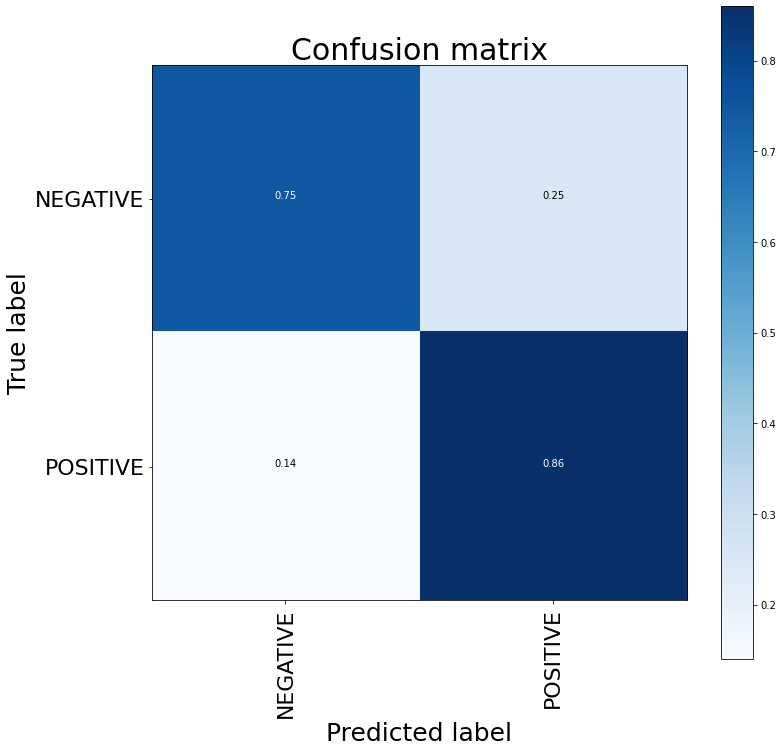

CPU times: user 276 ms, sys: 7.88 ms, total: 283 ms
Wall time: 287 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Acertividad

In [ ]:
acc = accuracy_score(y_test_1d, y_pred_1d)
print(acc)

0.7998359310910582


In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.86      0.75      0.80       649
    POSITIVE       0.75      0.86      0.80       570

    accuracy                           0.80      1219
   macro avg       0.80      0.80      0.80      1219
weighted avg       0.81      0.80      0.80      1219



# Salvar modelos

In [ ]:
  model.save(KERAS_MODEL)
  w2v_model.save(WORD2VEC_MODEL)
  pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
  pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-08-10 15:51:19,545 : INFO : saving Word2Vec object under /content/drive/MyDrive/Mercantil/model2.w2v, separately None
2022-08-10 15:51:19,548 : INFO : not storing attribute vectors_norm
2022-08-10 15:51:19,552 : INFO : not storing attribute cum_table
2022-08-10 15:51:19,576 : INFO : saved /content/drive/MyDrive/Mercantil/model2.w2v


In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-08-05 19:37:51,400 : INFO : saving Word2Vec object under /content/drive/MyDrive/Mercantil/model.w2v, separately None
2022-08-05 19:37:51,406 : INFO : not storing attribute vectors_norm
2022-08-05 19:37:51,410 : INFO : not storing attribute cum_table
2022-08-05 19:37:52,149 : INFO : saved /content/drive/MyDrive/Mercantil/model.w2v
